# FTIR Peak Deviation Regression

Predict spectral peak shift and magnitude deviation caused by defects in metasurface arrays.

**Objective**: Given where defects are and what kind they are, how much do they perturb the dominant FTIR peak?

- **Targets**: `delta_peak_wl`, `delta_peak_mag` (relative to zero-defect baseline)
- **Inputs**: defect type counts, defect distance geometry, global spatial context
- **No spectral inputs, no leakage**

---

In [1]:
import sys
import os
from pathlib import Path

# Add src directory to path
current_dir = Path(os.getcwd())
root_dir = current_dir.parent if current_dir.name == 'notebooks' else current_dir
src_dir = str(root_dir / "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

import os, sys
from pathlib import Path

# Resolve project root
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Define base directory explicitly
BASE_DIR = str(PROJECT_ROOT)

# Directory containing FTIR .dpt files
FTIR_DIR = os.path.join(BASE_DIR, "data")

# Ensure project root is on path
if BASE_DIR not in sys.path:
    sys.path.insert(0, BASE_DIR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")

from defect_analysis.ml import ftir_utils, feature_extraction, dataset_assembly, ml_models

plt.rcParams.update({
    "figure.dpi": 120, "font.size": 10, "axes.titlesize": 12,
    "axes.labelsize": 10, "figure.facecolor": "white",
})

CSV_PATH = os.path.join(BASE_DIR, "results", "meta_atoms_classified.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "ml_outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"FTIR data dir: {FTIR_DIR}")
print(f"Classification CSV: {CSV_PATH}")

Project root: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects
FTIR data dir: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\data
Classification CSV: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\results\meta_atoms_classified.csv


## Step 1 -- Visualization of Global Trends (Context)

We visualize the **Global Mean Spectrum** for each array to understand overall behavior.
**Note**: For regression targets (Step 2), we use a **Local Neighbor Baseline** to robustly isolate defects from smooth illumination variations.


In [2]:
# Load FTIR data
array_data = ftir_utils.load_all_arrays(FTIR_DIR)
for stem, (wl, sp) in array_data.items():
    print(f'{stem}: {sp.shape[1]} spectra, {sp.shape[0]} spectral points, '
          f'wavelength {wl[0]:.2f}-{wl[-1]:.2f} um')

# Load classifications
classifications = ftir_utils.load_classifications(CSV_PATH)
for arr_name, pillar_map in classifications.items():
    defect_counts = {}
    for dt in pillar_map.values():
        defect_counts[dt] = defect_counts.get(dt, 0) + 1
    print(f'{arr_name}: {defect_counts}')

Array_1.0: 169 spectra, 1763 spectral points, wavelength 2.50-16.67 um
Array_2.0: 169 spectra, 1763 spectral points, wavelength 2.50-16.67 um
Array_3.0: 169 spectra, 1763 spectral points, wavelength 2.50-16.67 um
Array_4.0: 169 spectra, 1763 spectral points, wavelength 2.50-16.67 um
Array_1Crop: {'Good': 340, 'Missing': 31, 'Collapsed': 31, 'Stitching': 36, 'Irregular': 3}
Array_2Crop: {'Good': 390, 'Stitching': 19, 'Irregular': 7, 'Missing': 15, 'Collapsed': 10}
Array_3Crop: {'Good': 367, 'Missing': 24, 'Irregular': 8, 'Collapsed': 30, 'Stitching': 12}


### 1.2 Identify zero-defect windows and compute baselines

In [3]:
# Build window compositions for all arrays
array_stems_labeled = ['Array_1.0', 'Array_2.0', 'Array_3.0']
wl_ref = array_data[array_stems_labeled[0]][0]

baselines = {}
zero_defect_counts = {}

for stem in array_stems_labeled:
    wl, sp = array_data[stem]
    comps = ftir_utils.build_all_window_compositions(classifications, stem)
    comp_df = pd.DataFrame(comps)
    
    # Use global mean as baseline (robust to arrays with no zero-defect windows)
    ref_indices = np.arange(sp.shape[1])  # Use ALL spectra
    
    # Keep counting zero defects for stats/reporting
    zero_mask = comp_df['is_zero_defect'].values
    zero_indices = np.where(zero_mask)[0]
    zero_defect_counts[stem] = len(zero_indices)
    
    # Compute baseline from ALL indices (Array Mean)
    ideal_spec, ideal_wl, ideal_mag, _ = feature_extraction.compute_ideal_baseline(
        wl, sp, ref_indices
    )
    baselines[stem] = {
        'ideal_spectrum': ideal_spec,
        'ideal_peak_wl': ideal_wl,
        'ideal_peak_mag': ideal_mag,
        'n_zero_defect': len(zero_indices),
    }
    
    print(f'{stem}: {len(zero_indices)}/169 zero-defect windows')
    print(f'  Ideal peak: {ideal_wl:.4f} um, magnitude: {ideal_mag:.6f}')

Array_1.0: 0/169 zero-defect windows
  Ideal peak: 7.2623 um, magnitude: 0.466492
Array_2.0: 0/169 zero-defect windows
  Ideal peak: 7.3759 um, magnitude: 0.528378
Array_3.0: 0/169 zero-defect windows
  Ideal peak: 7.3654 um, magnitude: 0.500711


### 1.3 Visualize ideal spectra and reference peaks

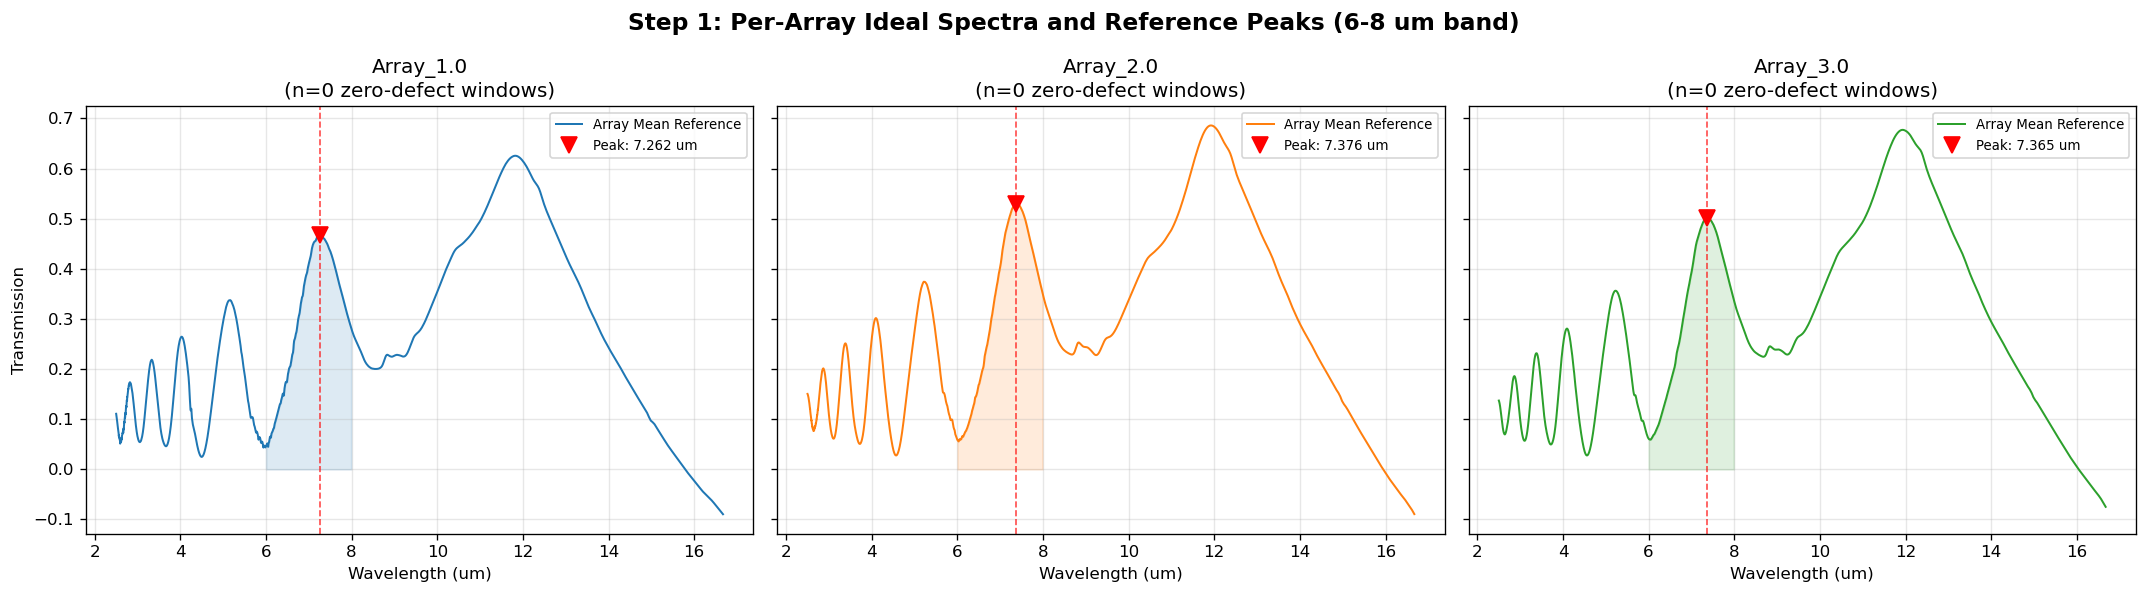

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
colors_arr = ['#1f77b4', '#ff7f0e', '#2ca02c']

for ax, stem, color in zip(axes, array_stems_labeled, colors_arr):
    bl = baselines[stem]
    wl = array_data[stem][0]
    
    # Full ideal spectrum
    ax.plot(wl, bl['ideal_spectrum'], color=color, linewidth=1.2, label='Array Mean Reference')
    
    # Highlight 6-8 um band
    band_mask = feature_extraction.get_band_mask(wl)
    ax.fill_between(wl[band_mask], 0, bl['ideal_spectrum'][band_mask],
                    alpha=0.15, color=color)
    
    # Mark the reference peak
    ax.axvline(bl['ideal_peak_wl'], color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.plot(bl['ideal_peak_wl'], bl['ideal_peak_mag'], 'rv', markersize=10,
            label=f'Peak: {bl["ideal_peak_wl"]:.3f} um')
    
    ax.set_title(f'{stem}\n(n={bl["n_zero_defect"]} zero-defect windows)')
    ax.set_xlabel('Wavelength (um)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Transmission')
fig.suptitle('Step 1: Per-Array Ideal Spectra and Reference Peaks (6-8 um band)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step1_ideal_spectra.png'), dpi=150, bbox_inches='tight')
plt.show()

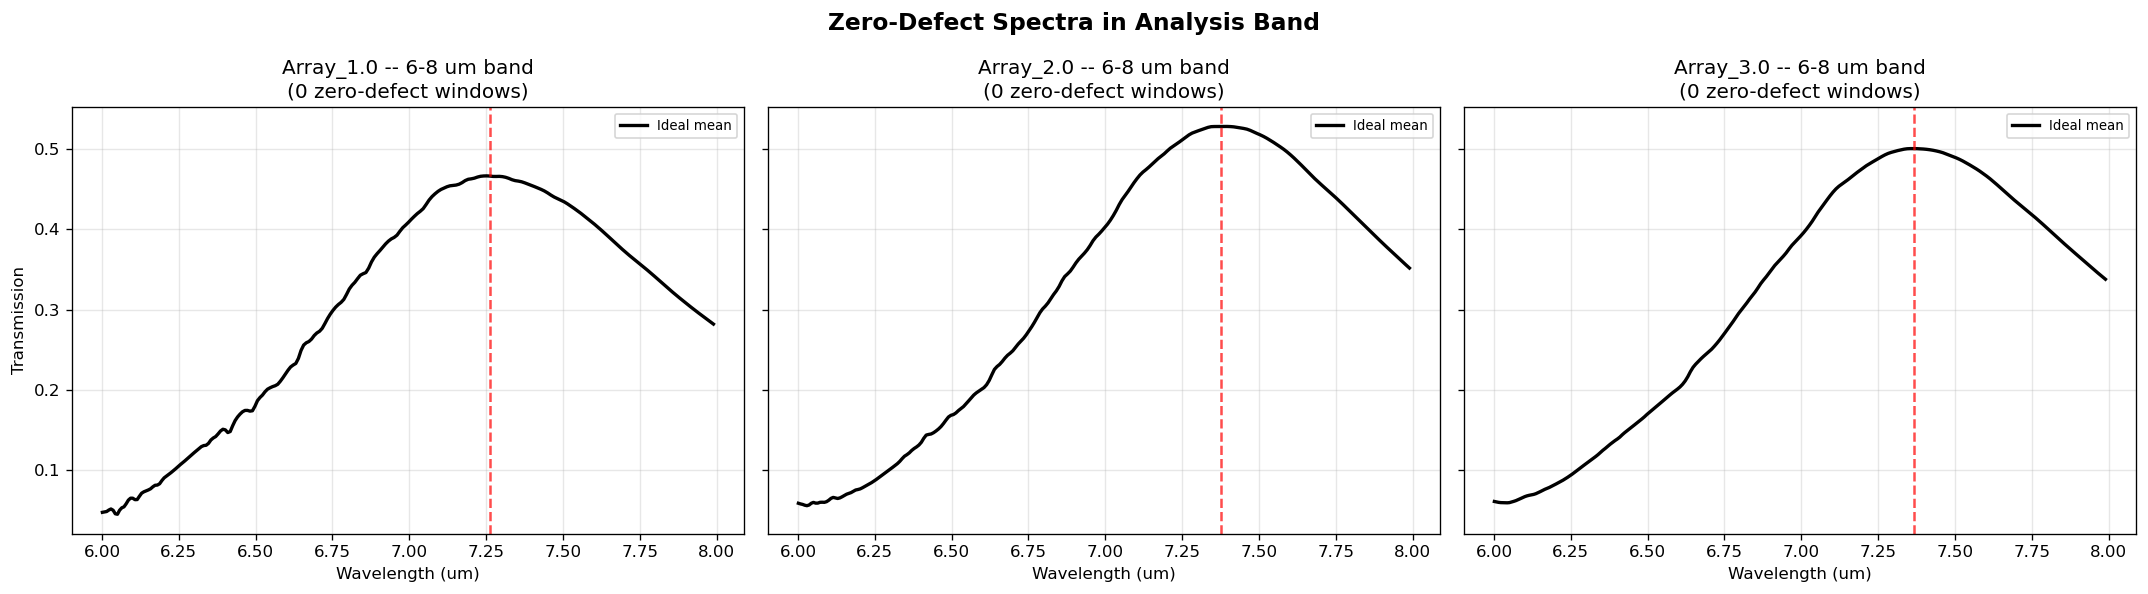

In [5]:
# Zoomed view: 6-8 um band with individual zero-defect spectra
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, stem, color in zip(axes, array_stems_labeled, colors_arr):
    wl, sp = array_data[stem]
    comps = ftir_utils.build_all_window_compositions(classifications, stem)
    comp_df = pd.DataFrame(comps)
    zero_indices = np.where(comp_df['is_zero_defect'].values)[0]
    
    band_mask = feature_extraction.get_band_mask(wl)
    wl_band = wl[band_mask]
    
    # Plot individual zero-defect spectra
    for idx in zero_indices:
        ax.plot(wl_band, sp[band_mask, idx], color=color, alpha=0.15, linewidth=0.5)
    
    # Ideal mean
    bl = baselines[stem]
    ax.plot(wl_band, bl['ideal_spectrum'][band_mask], color='black', linewidth=2,
            label='Ideal mean')
    ax.axvline(bl['ideal_peak_wl'], color='red', linestyle='--', alpha=0.7)
    
    ax.set_title(f'{stem} -- 6-8 um band\n({len(zero_indices)} zero-defect windows)')
    ax.set_xlabel('Wavelength (um)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Transmission')
fig.suptitle('Zero-Defect Spectra in Analysis Band', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step1_zero_defect_band.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 2 -- Refined Target Variables (Local + Spatial Removal)

We compute advanced targets to handle illumination non-uniformity:
1. **Local Delta**: `val - mean(neighbors)` (Cancels smooth field)
2. **Spatial Residual**: Subtract fitted polynomial field from Local Delta Magnitude.
3. **Relative Metrics**: Extract `peak_prominence`.

### 2.1 Build the dataset with refined targets


In [6]:
print('Building master dataset...')
master_df, bl_info = dataset_assembly.build_master_dataset(array_data, classifications)
print(f'\nMaster dataset: {master_df.shape[0]} rows, {master_df.shape[1]} columns')
print(f'Columns: {list(master_df.columns)}')
master_df.head(10)

Building master dataset...
  Assembling Array_1.0 ...
    Processed 169 measurements.
  Assembling Array_2.0 ...
    Processed 169 measurements.
  Assembling Array_3.0 ...
    Processed 169 measurements.

Master dataset: 507 rows, 25 columns
Columns: ['n_missing', 'n_collapsed', 'n_stitching', 'n_irregular', 'n_total_defects', 'is_zero_defect', 'min_defect_dist', 'mean_defect_dist', 'sum_1_over_dist', 'meas_idx', 'local_i', 'local_j', 'global_row', 'global_col', 'dist_from_center', 'raw_peak_wl', 'raw_peak_mag', 'peak_prominence', 'delta_peak_wl', 'delta_peak_mag_raw', 'delta_peak_mag', 'array_id', 'array', 'norm_row', 'norm_col']


,n_missing,n_collapsed,n_stitching,n_irregular,n_total_defects,is_zero_defect,min_defect_dist,mean_defect_dist,sum_1_over_dist,meas_idx,...,raw_peak_wl,raw_peak_mag,peak_prominence,delta_peak_wl,delta_peak_mag_raw,delta_peak_mag,array_id,array,norm_row,norm_col
0,8,7,0,0,15,False,26.832816,42.980325,0.375006,1,...,7.142232,0.621628,0.279668,-0.069544,-0.032081,-0.020638,1,Array_1.0,0.75,-1.000000
1,8,7,0,1,16,False,24.000000,46.267082,0.378593,2,...,7.201751,0.649563,0.290586,-0.004150,-0.009644,-0.003482,1,Array_1.0,0.75,-0.833333
2,8,4,9,1,22,False,24.000000,50.277139,0.478022,3,...,7.221812,0.671166,0.301617,-0.004051,-0.016430,-0.014355,1,Array_1.0,0.75,-0.666667
3,6,2,18,1,27,False,26.832816,48.762619,0.592331,4,...,7.231884,0.702624,0.319014,-0.004051,-0.004835,-0.005651,1,Array_1.0,0.75,-0.500000
4,6,2,18,1,27,False,24.000000,42.844008,0.677207,5,...,7.231884,0.713251,0.321289,-0.016189,-0.010784,-0.013298,1,Array_1.0,0.75,-0.333333
5,6,2,18,1,27,False,12.000000,37.920684,0.838401,6,...,7.252113,0.716359,0.319391,-0.000017,-0.014159,-0.017175,1,Array_1.0,0.75,-0.166667
6,6,3,18,1,28,False,0.000000,34.910120,1.776979,7,...,7.252113,0.720054,0.321177,-0.006094,-0.013050,-0.015375,1,Array_1.0,0.75,0.000000
7,5,5,18,1,29,False,0.000000,34.907863,1.809613,8,...,7.252113,0.721594,0.321174,-0.006094,-0.008312,-0.008750,1,Array_1.0,0.75,0.166667
8,4,6,18,1,29,False,12.000000,36.265737,0.929719,9,...,7.252113,0.709309,0.313819,-0.002037,-0.005440,-0.002797,1,Array_1.0,0.75,0.333333
9,4,6,18,1,29,False,12.000000,39.254730,0.844025,10,...,7.241984,0.676231,0.296013,-0.002054,-0.005803,0.001116,1,Array_1.0,0.75,0.500000


### 2.2 Target distributions

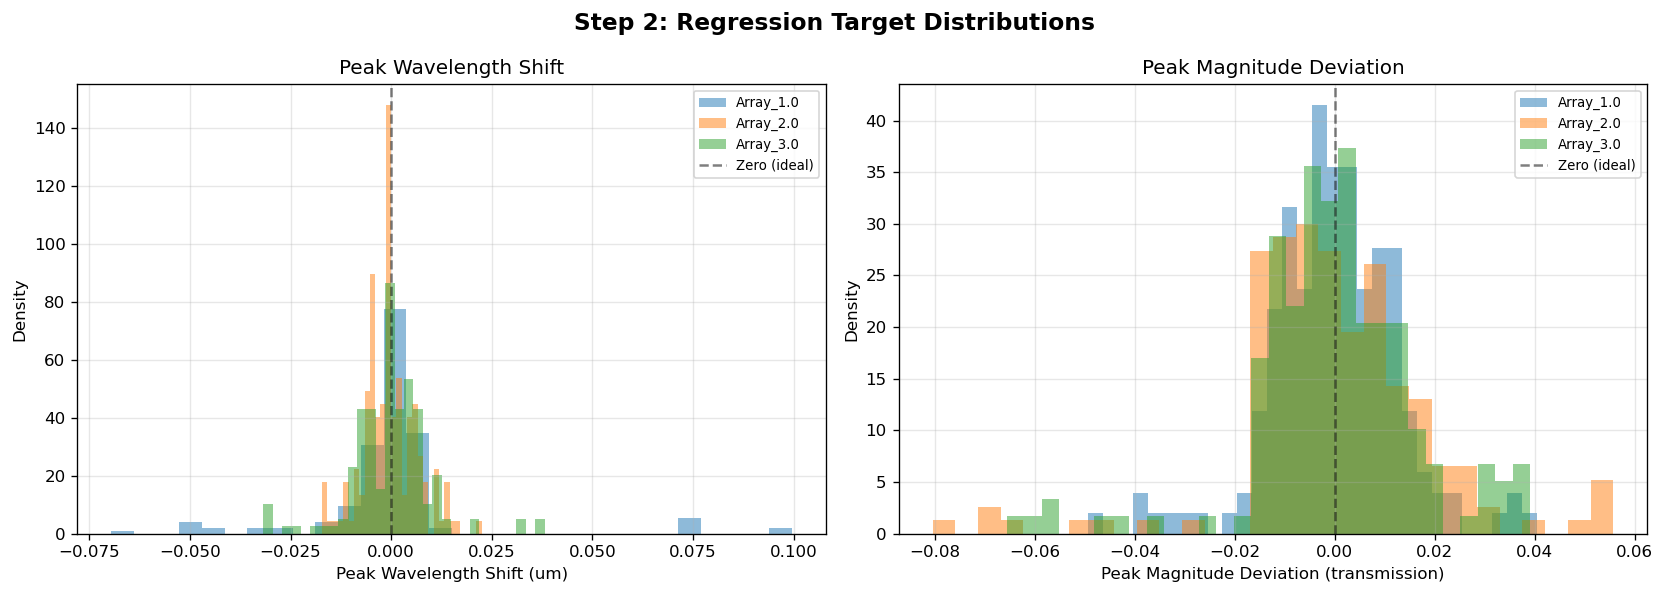

Target statistics:
       delta_peak_wl  delta_peak_mag
count     507.000000    5.070000e+02
mean        0.000104   -4.012788e-17
std         0.013872    1.665117e-02
min        -0.069544   -8.046005e-02
25%        -0.004051   -8.394580e-03
50%         0.000000   -1.900132e-04
75%         0.003936    9.026988e-03
max         0.099594    5.568574e-02


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, title, unit in zip(
    axes,
    ['delta_peak_wl', 'delta_peak_mag'],
    ['Peak Wavelength Shift', 'Peak Magnitude Deviation'],
    ['um', 'transmission']
):
    for stem, color in zip(array_stems_labeled, colors_arr):
        vals = master_df.loc[master_df['array'] == stem, col]
        ax.hist(vals, bins=30, alpha=0.5, color=color, label=stem, density=True)
    ax.set_xlabel(f'{title} ({unit})')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Zero (ideal)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle('Step 2: Regression Target Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step2_target_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

print('Target statistics:')
print(master_df[['delta_peak_wl', 'delta_peak_mag']].describe())

---
## Step 3 -- Input Features

Strictly controlled: defect counts, defect geometry, global spatial context. No spectral inputs.

### 3.1 Input feature summary

In [8]:
print('Input features:')
print(dataset_assembly.INPUT_COLS)
print()
print('Target columns:')
print(dataset_assembly.TARGET_COLS)
print()
print('Input feature statistics:')
print(master_df[dataset_assembly.INPUT_COLS].describe().round(3))

Input features:
['n_missing', 'n_collapsed', 'n_stitching', 'n_irregular', 'n_total_defects', 'min_defect_dist', 'mean_defect_dist', 'sum_1_over_dist', 'global_row', 'global_col', 'dist_from_center', 'norm_row', 'norm_col']

Target columns:
['delta_peak_wl', 'delta_peak_mag', 'peak_prominence']

Input feature statistics:
       n_missing  n_collapsed  n_stitching  n_irregular  n_total_defects  \
count    507.000      507.000      507.000      507.000          507.000   
mean       3.972        4.465        6.586        1.213           16.237   
std        2.013        2.966        5.911        1.200            6.872   
min        0.000        0.000        0.000        0.000            2.000   
25%        2.000        2.500        0.000        0.000           11.000   
50%        4.000        4.000        7.000        1.000           15.000   
75%        6.000        6.000        9.000        2.000           20.500   
max        8.000       11.000       18.000        5.000           34.

### 3.2 Defect composition across measurement windows

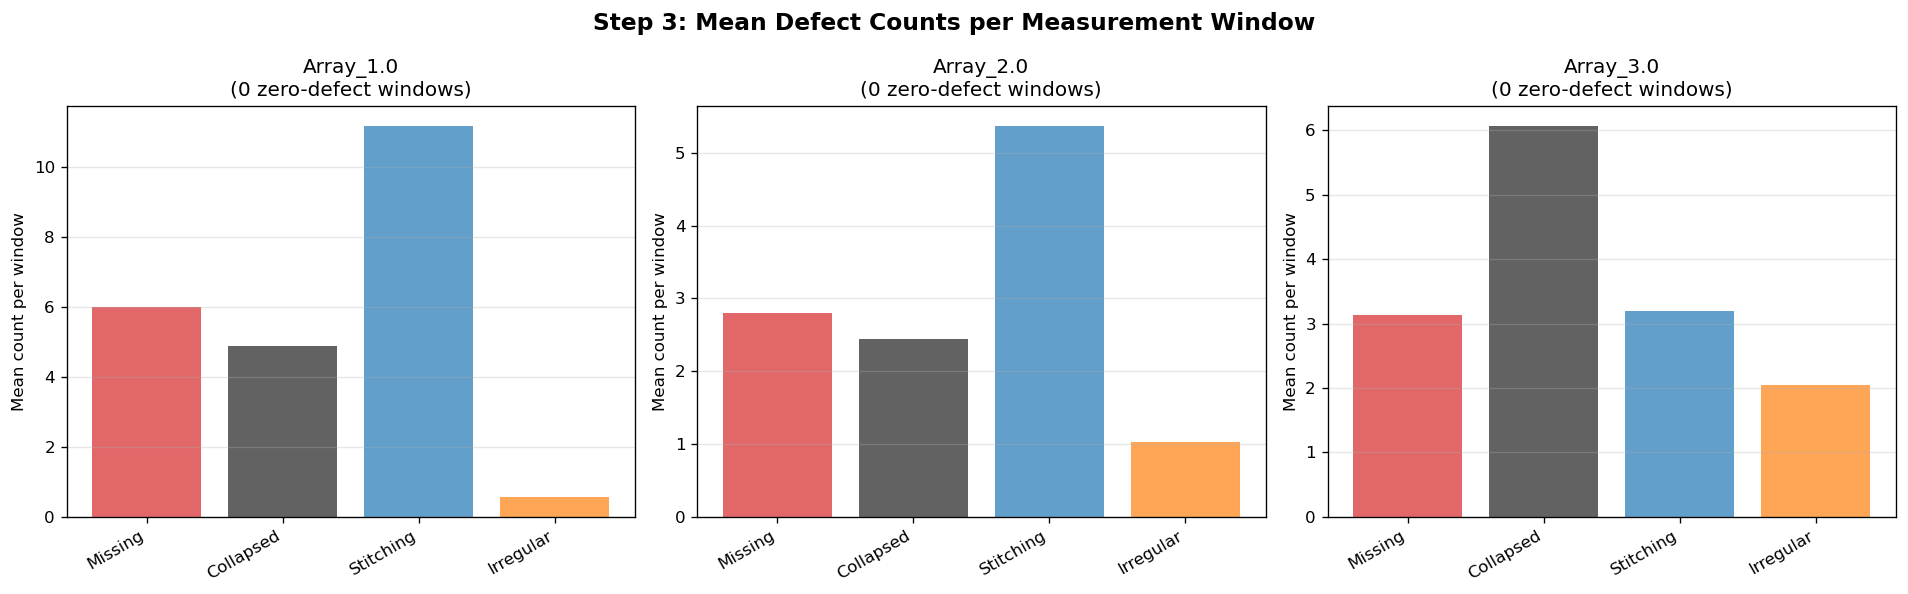

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, stem, color in zip(axes, array_stems_labeled, colors_arr):
    arr_df = master_df[master_df['array'] == stem]
    defect_cols = ['n_missing', 'n_collapsed', 'n_stitching', 'n_irregular']
    means = arr_df[defect_cols].mean()
    ax.bar(range(len(defect_cols)), means.values,
           color=['#d62728', '#1f1f1f', '#1f77b4', '#ff7f0e'], alpha=0.7)
    ax.set_xticks(range(len(defect_cols)))
    ax.set_xticklabels(['Missing', 'Collapsed', 'Stitching', 'Irregular'],
                        rotation=30, ha='right')
    ax.set_ylabel('Mean count per window')
    ax.set_title(f'{stem}\n({int(arr_df["is_zero_defect"].sum())} zero-defect windows)')
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Step 3: Mean Defect Counts per Measurement Window', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step3_defect_composition.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Spatial maps: defect count and target values over the 13x13 grid

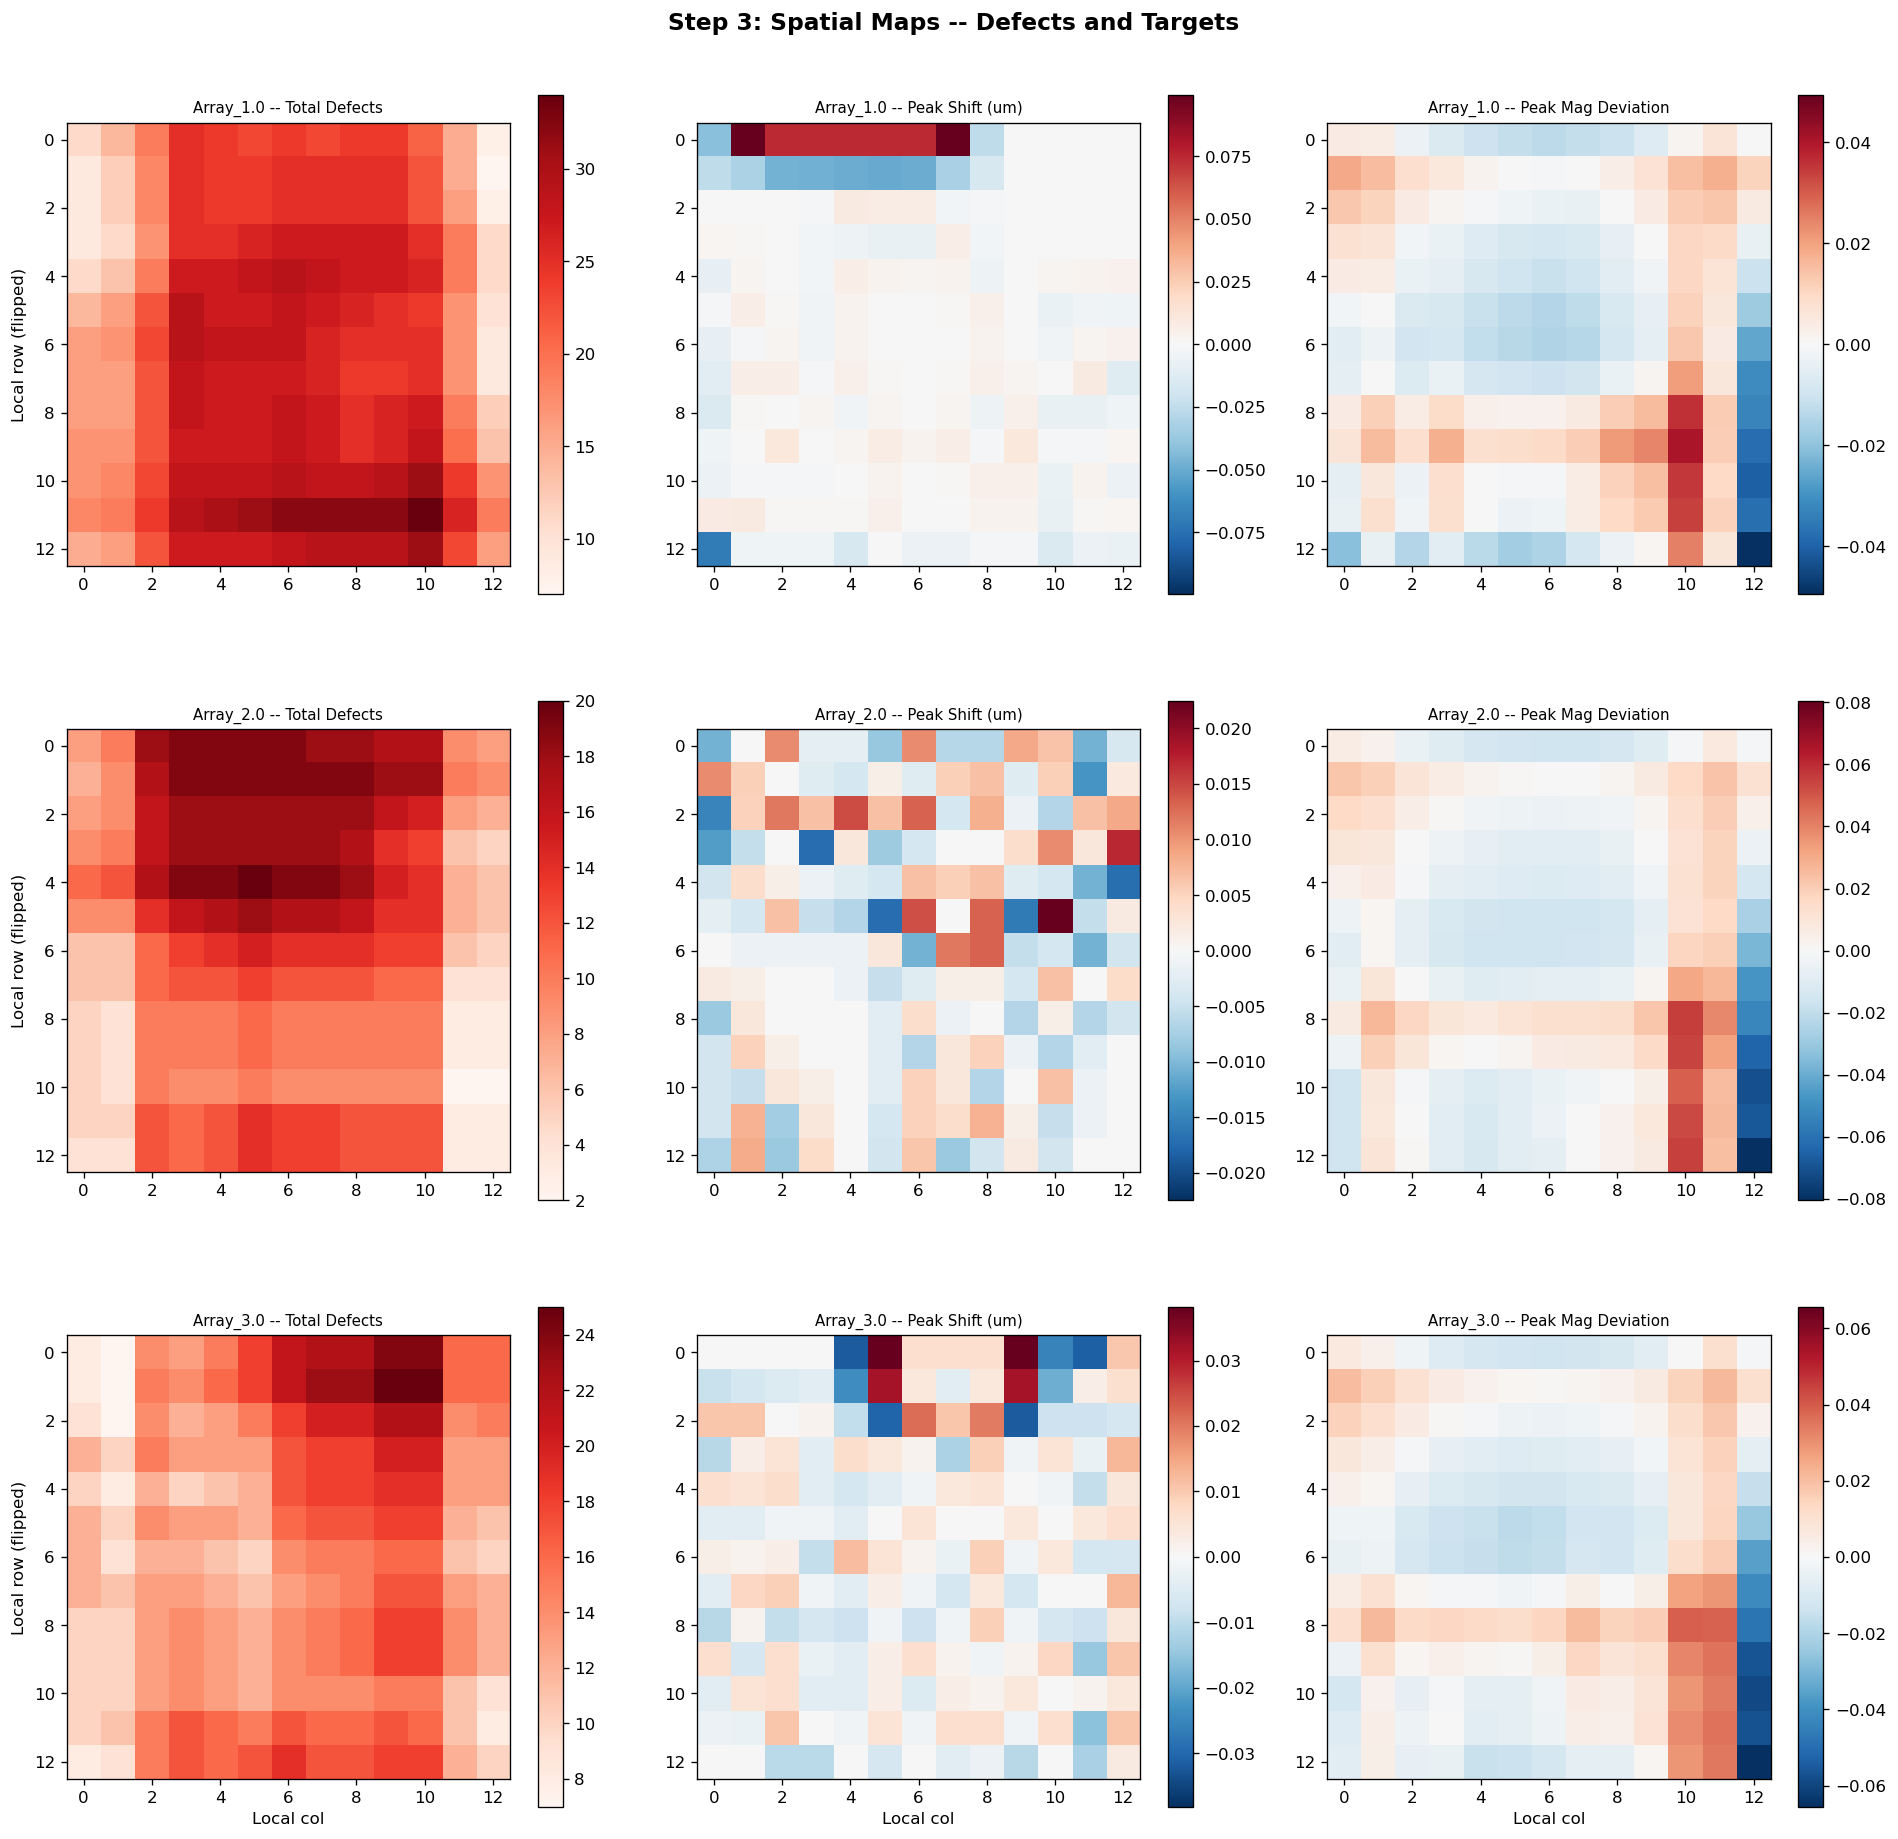

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

plot_vars = ['n_total_defects', 'delta_peak_wl', 'delta_peak_mag']
cmaps = ['Reds', 'RdBu_r', 'RdBu_r']
titles = ['Total Defects', 'Peak Shift (um)', 'Peak Mag Deviation']

for col_idx, (var, cmap, title) in enumerate(zip(plot_vars, cmaps, titles)):
    for row_idx, stem in enumerate(array_stems_labeled):
        ax = axes[row_idx, col_idx]
        arr_df = master_df[master_df['array'] == stem]
        
        grid = np.full((13, 13), np.nan)
        for _, row in arr_df.iterrows():
            i, j = int(row['local_i']), int(row['local_j'])
            grid[12 - i, j] = row[var]  # flip for display
        
        if var == 'n_total_defects':
            im = ax.imshow(grid, cmap=cmap, aspect='equal')
        else:
            vmax = np.nanmax(np.abs(grid))
            im = ax.imshow(grid, cmap=cmap, aspect='equal',
                          vmin=-vmax, vmax=vmax)
        
        ax.set_title(f'{stem} -- {title}', fontsize=9)
        plt.colorbar(im, ax=ax, shrink=0.8)
        
        if col_idx == 0:
            ax.set_ylabel('Local row (flipped)')
        if row_idx == 2:
            ax.set_xlabel('Local col')

fig.suptitle('Step 3: Spatial Maps -- Defects and Targets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step3_spatial_maps.png'), dpi=150, bbox_inches='tight')
plt.show()

---
## Step 4 -- Dataset Structure and Save

Verify final dataset structure and save.

In [11]:
# Handle NaN in distance features (zero-defect windows have NaN distances)
# Fill with sentinel values that reflect "no defect nearby"
dist_fill = {
    'min_defect_dist': master_df['min_defect_dist'].max() * 2 if master_df['min_defect_dist'].notna().any() else 999.0,
    'mean_defect_dist': master_df['mean_defect_dist'].max() * 2 if master_df['mean_defect_dist'].notna().any() else 999.0,
}
master_filled = master_df.copy()
master_filled.fillna(dist_fill, inplace=True)

# Save
master_path = os.path.join(OUTPUT_DIR, 'regression_dataset.csv')
master_filled.to_csv(master_path, index=False)
print(f'Saved: {master_path} ({len(master_filled)} rows)')

# Show the final structure
print(f'\nDataset columns ({len(master_filled.columns)}):')
for c in master_filled.columns:
    role = 'TARGET' if c in dataset_assembly.TARGET_COLS else \
           'INPUT' if c in dataset_assembly.INPUT_COLS else 'META'
    print(f'  [{role:6s}] {c}')

print(f'\nInput features: {len(dataset_assembly.INPUT_COLS)}')
print(f'Targets: {len(dataset_assembly.TARGET_COLS)}')
print(f'Total rows: {len(master_filled)}')

Saved: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\ml_outputs\regression_dataset.csv (507 rows)

Dataset columns (25):
  [INPUT ] n_missing
  [INPUT ] n_collapsed
  [INPUT ] n_stitching
  [INPUT ] n_irregular
  [INPUT ] n_total_defects
  [META  ] is_zero_defect
  [INPUT ] min_defect_dist
  [INPUT ] mean_defect_dist
  [INPUT ] sum_1_over_dist
  [META  ] meas_idx
  [META  ] local_i
  [META  ] local_j
  [INPUT ] global_row
  [INPUT ] global_col
  [INPUT ] dist_from_center
  [META  ] raw_peak_wl
  [META  ] raw_peak_mag
  [TARGET] peak_prominence
  [TARGET] delta_peak_wl
  [META  ] delta_peak_mag_raw
  [TARGET] delta_peak_mag
  [META  ] array_id
  [META  ] array
  [INPUT ] norm_row
  [INPUT ] norm_col

Input features: 13
Targets: 3
Total rows: 507


## Step 5 -- Regression Models

Predicting:
- `delta_peak_wl` (Local Deviation)
- `delta_peak_mag` (Local Deviation + Spatial Residual)
- `peak_prominence` (Relative Metric)


In [12]:
X = master_filled[dataset_assembly.INPUT_COLS].values
y_wl = master_filled['delta_peak_wl'].values
y_mag = master_filled['delta_peak_mag'].values

print(f'Feature matrix: {X.shape}')
print(f'Any NaN in X: {np.isnan(X).any()}')
print(f'Any NaN in y_wl: {np.isnan(y_wl).any()}')
print(f'Any NaN in y_mag: {np.isnan(y_mag).any()}')

Feature matrix: (507, 13)
Any NaN in X: False
Any NaN in y_wl: False
Any NaN in y_mag: False


### 5.2 Train models for delta_peak_wl

In [13]:
print('=== Predicting delta_peak_wl ===')
print()

results_wl = {}

results_wl['Ridge'] = ml_models.train_ridge(X, y_wl)
ml_models.model_summary(results_wl['Ridge'], 'Ridge')

results_wl['ElasticNet'] = ml_models.train_elasticnet(X, y_wl)
ml_models.model_summary(results_wl['ElasticNet'], 'ElasticNet')

results_wl['RF'] = ml_models.train_rf(X, y_wl)
ml_models.model_summary(results_wl['RF'], 'RF')

xgb_res = ml_models.train_xgboost(X, y_wl)
if xgb_res is not None:
    results_wl['XGBoost'] = xgb_res
    ml_models.model_summary(xgb_res, 'XGBoost')

=== Predicting delta_peak_wl ===

  Ridge            R2=-0.0177  RMSE=0.013830
  ElasticNet       R2=-0.0073  RMSE=0.013745
  RF               R2=+0.0948  RMSE=0.012901


### 5.3 Train models for delta_peak_mag

In [14]:
print('=== Predicting delta_peak_mag ===')
print()

results_mag = {}

results_mag['Ridge'] = ml_models.train_ridge(X, y_mag)
ml_models.model_summary(results_mag['Ridge'], 'Ridge')

results_mag['ElasticNet'] = ml_models.train_elasticnet(X, y_mag)
ml_models.model_summary(results_mag['ElasticNet'], 'ElasticNet')

results_mag['RF'] = ml_models.train_rf(X, y_mag)
ml_models.model_summary(results_mag['RF'], 'RF')

xgb_res = ml_models.train_xgboost(X, y_mag)
if xgb_res is not None:
    results_mag['XGBoost'] = xgb_res
    ml_models.model_summary(xgb_res, 'XGBoost')

=== Predicting delta_peak_mag ===

  Ridge            R2=+0.0625  RMSE=0.016055
  ElasticNet       R2=-0.0050  RMSE=0.016615
  RF               R2=+0.9126  RMSE=0.004853


---
## Step 6 -- Diagnostics

### 6.1 Predicted vs True

Best model for delta_peak_wl:  RF (R2=0.0948)
Best model for delta_peak_mag: RF (R2=0.9126)


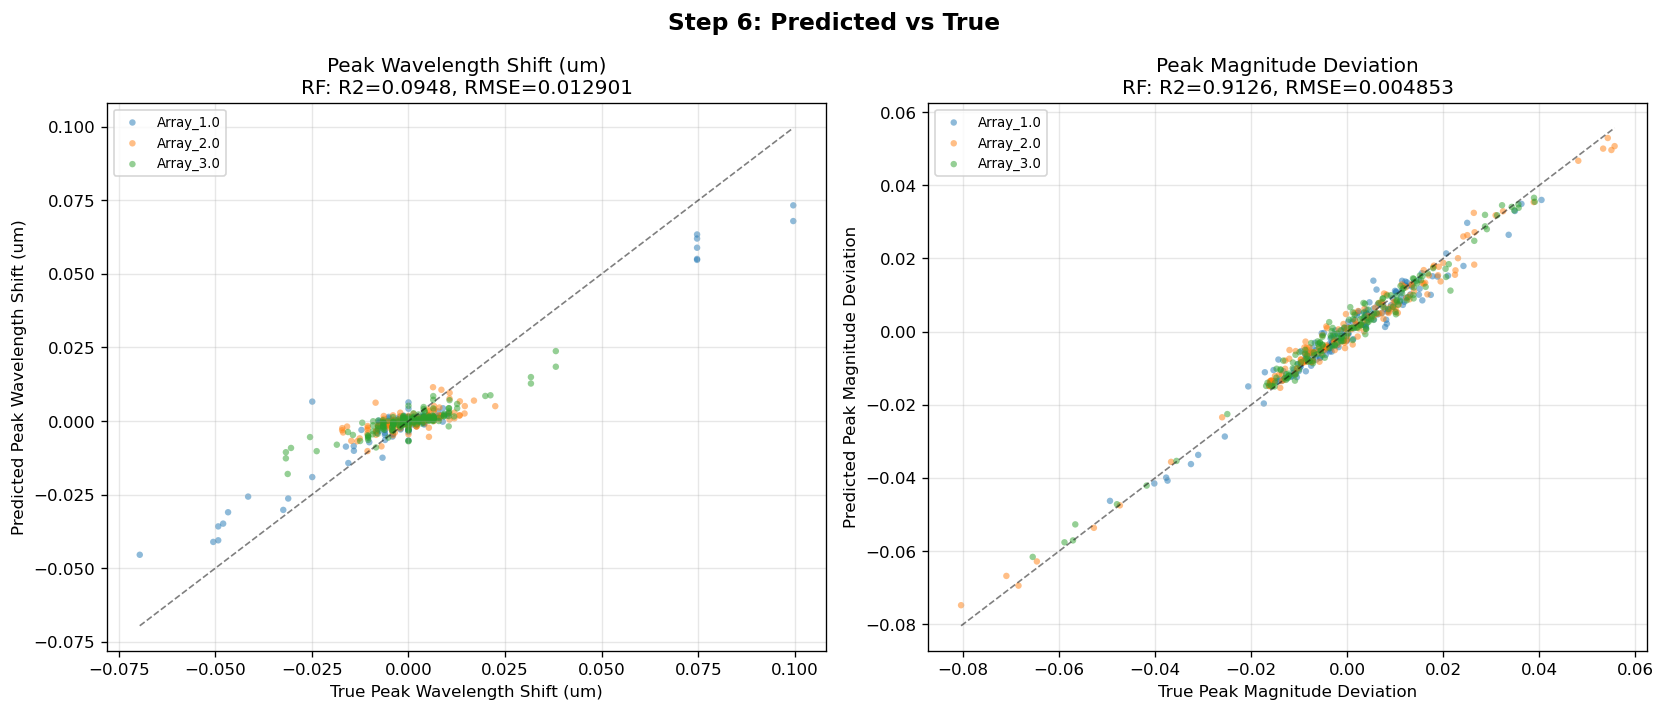

In [15]:
# Select best models for each target (use RF as default)
best_wl_name = max(results_wl, key=lambda k: results_wl[k]['mean_r2'])
best_mag_name = max(results_mag, key=lambda k: results_mag[k]['mean_r2'])

print(f'Best model for delta_peak_wl:  {best_wl_name} (R2={results_wl[best_wl_name]["mean_r2"]:.4f})')
print(f'Best model for delta_peak_mag: {best_mag_name} (R2={results_mag[best_mag_name]["mean_r2"]:.4f})')

pred_wl = ml_models.predict(results_wl[best_wl_name], X)
pred_mag = ml_models.predict(results_mag[best_mag_name], X)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, y_true, y_pred, title, best_name, results_dict in zip(
    axes,
    [y_wl, y_mag],
    [pred_wl, pred_mag],
    ['Peak Wavelength Shift (um)', 'Peak Magnitude Deviation'],
    [best_wl_name, best_mag_name],
    [results_wl, results_mag]
):
    for stem, color in zip(array_stems_labeled, colors_arr):
        mask = master_filled['array'] == stem
        ax.scatter(y_true[mask], y_pred[mask], s=15, alpha=0.5,
                   color=color, label=stem, edgecolors='none')
    
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=1)
    ax.set_xlabel(f'True {title}')
    ax.set_ylabel(f'Predicted {title}')
    r2 = results_dict[best_name]['mean_r2']
    rmse = results_dict[best_name]['mean_rmse']
    ax.set_title(f'{title}\n{best_name}: R2={r2:.4f}, RMSE={rmse:.6f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle('Step 6: Predicted vs True', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step6_pred_vs_true.png'), dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Residual heatmaps over 13x13 grid

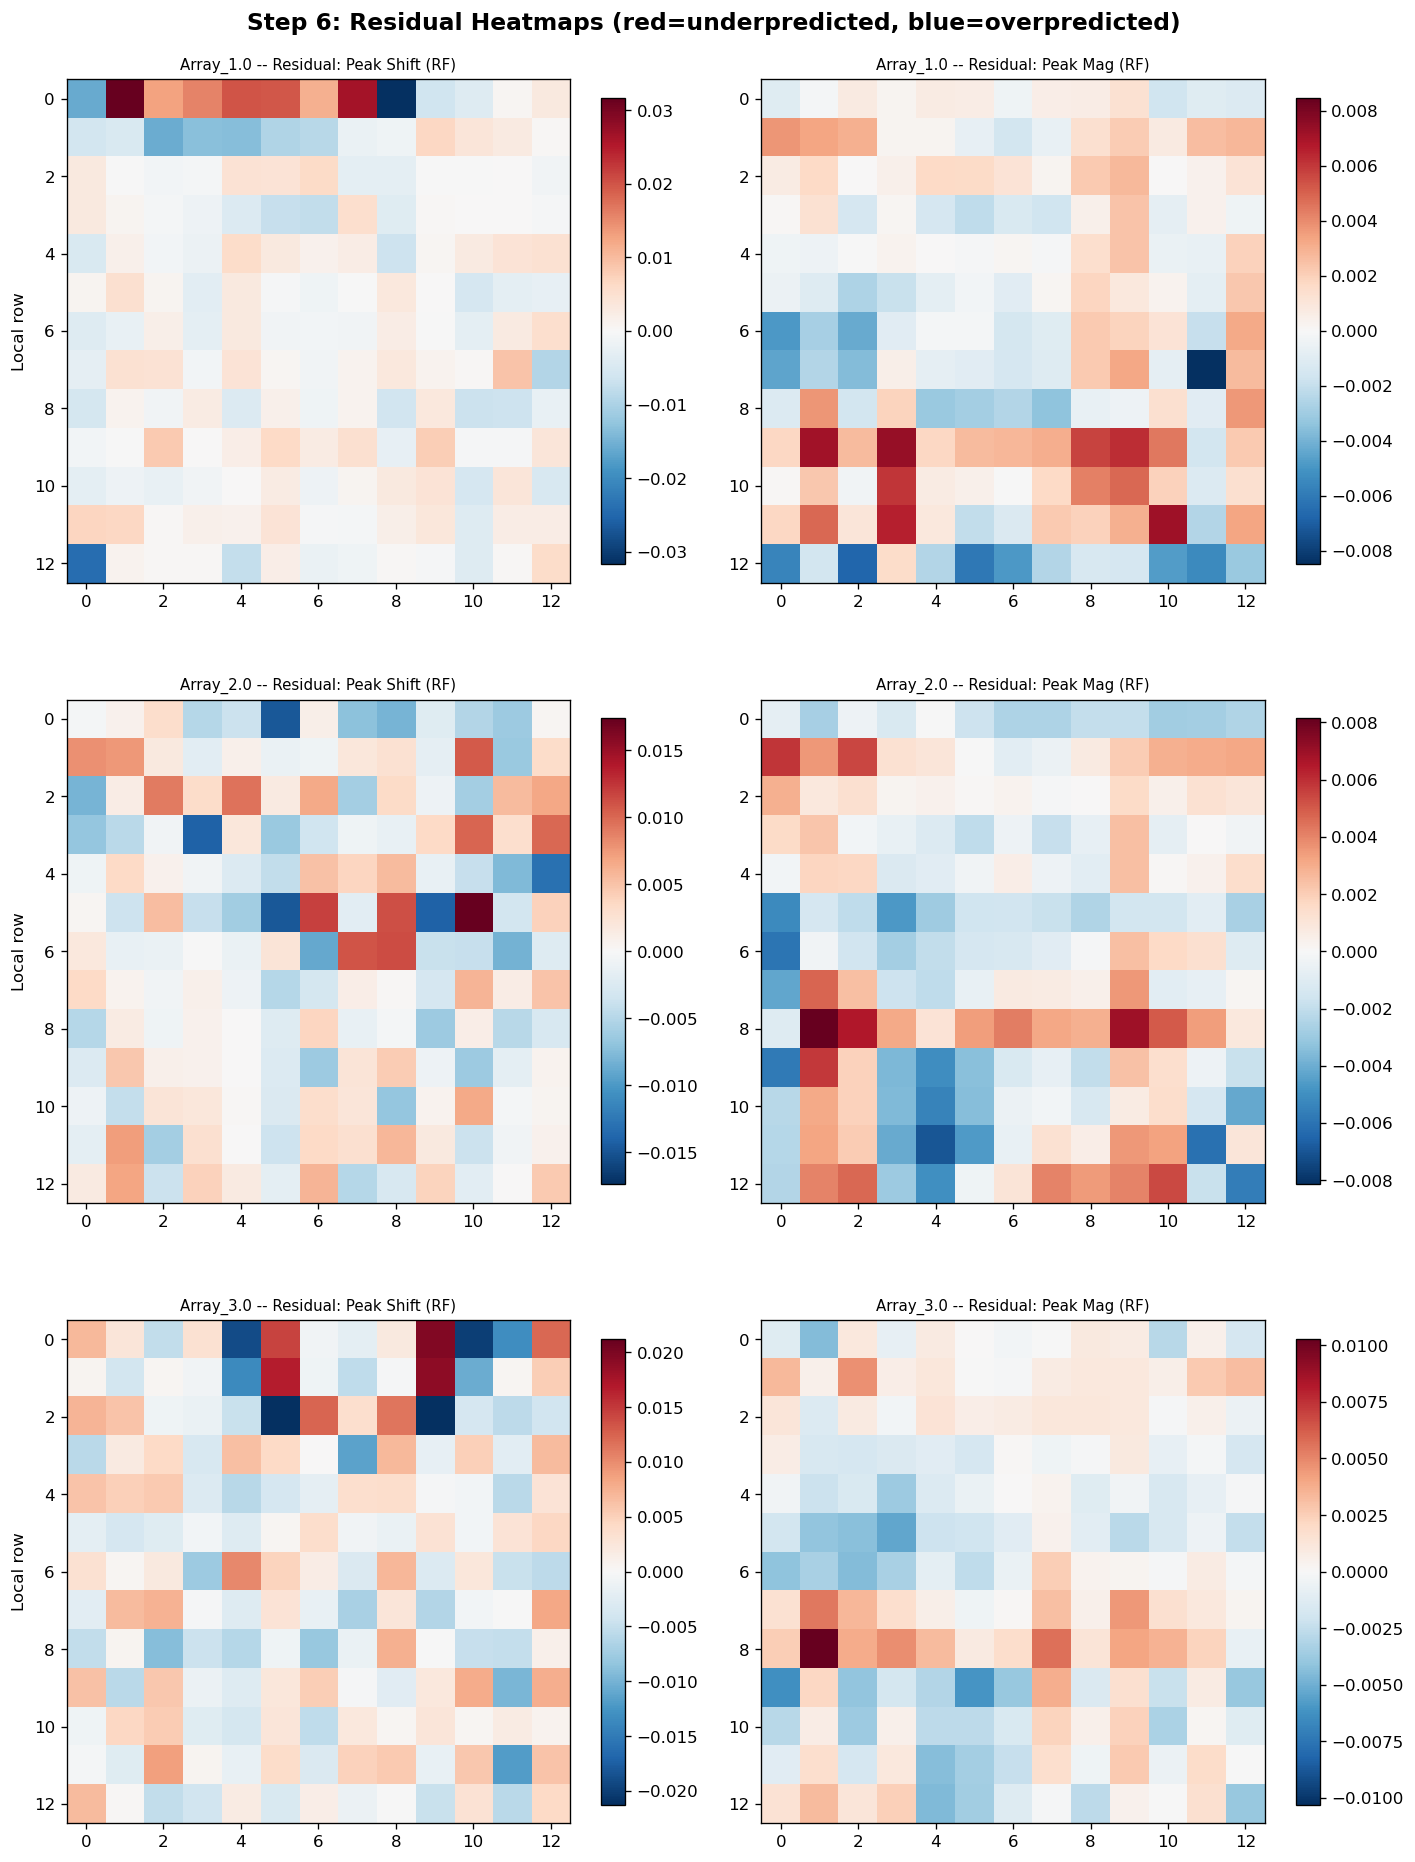

In [16]:
resid_wl = ml_models.residuals(y_wl, pred_wl)
resid_mag = ml_models.residuals(y_mag, pred_mag)
master_filled['resid_wl'] = resid_wl
master_filled['resid_mag'] = resid_mag

fig, axes = plt.subplots(3, 2, figsize=(12, 16))

for row_idx, stem in enumerate(array_stems_labeled):
    arr_df = master_filled[master_filled['array'] == stem]
    
    for col_idx, (var, title) in enumerate([
        ('resid_wl', f'Residual: Peak Shift ({best_wl_name})'),
        ('resid_mag', f'Residual: Peak Mag ({best_mag_name})')
    ]):
        ax = axes[row_idx, col_idx]
        grid = np.full((13, 13), np.nan)
        for _, row in arr_df.iterrows():
            i, j = int(row['local_i']), int(row['local_j'])
            grid[12 - i, j] = row[var]
        
        vmax = np.nanmax(np.abs(grid))
        im = ax.imshow(grid, cmap='RdBu_r', aspect='equal', vmin=-vmax, vmax=vmax)
        ax.set_title(f'{stem} -- {title}', fontsize=9)
        plt.colorbar(im, ax=ax, shrink=0.8)
        if col_idx == 0:
            ax.set_ylabel('Local row')

fig.suptitle('Step 6: Residual Heatmaps (red=underpredicted, blue=overpredicted)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step6_residual_heatmaps.png'), dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Feature importance (tree models)

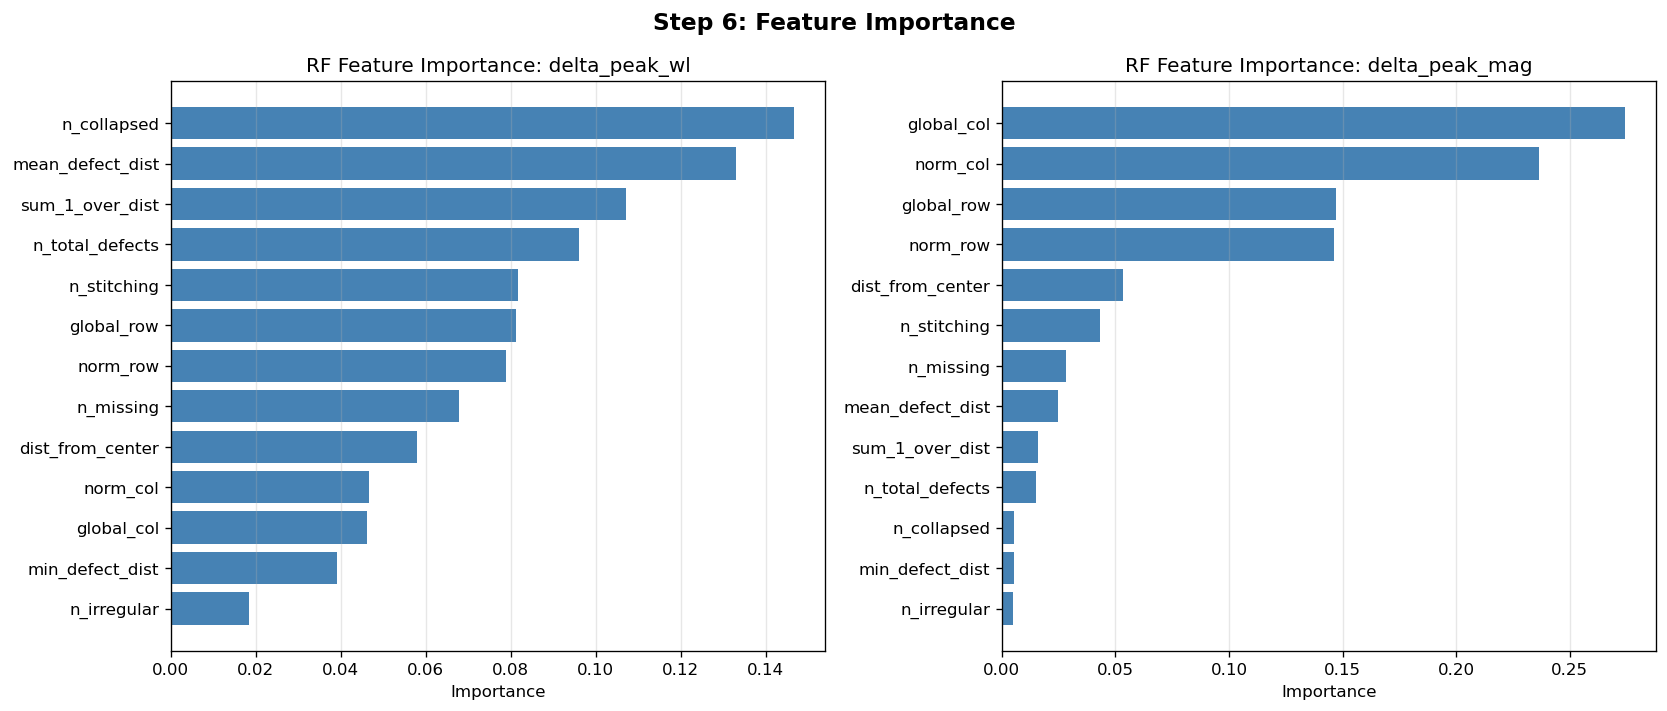

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, results_dict, target_name in zip(
    axes, [results_wl, results_mag], ['delta_peak_wl', 'delta_peak_mag']
):
    # Use RF (always available)
    imp_df = ml_models.get_feature_importance_df(
        results_dict['RF'], dataset_assembly.INPUT_COLS
    )
    if imp_df is not None:
        ax.barh(imp_df['feature'][::-1], imp_df['importance'][::-1],
                color='steelblue')
        ax.set_xlabel('Importance')
        ax.set_title(f'RF Feature Importance: {target_name}')
        ax.grid(True, alpha=0.3, axis='x')

fig.suptitle('Step 6: Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step6_feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

### 6.4 Linear model coefficients

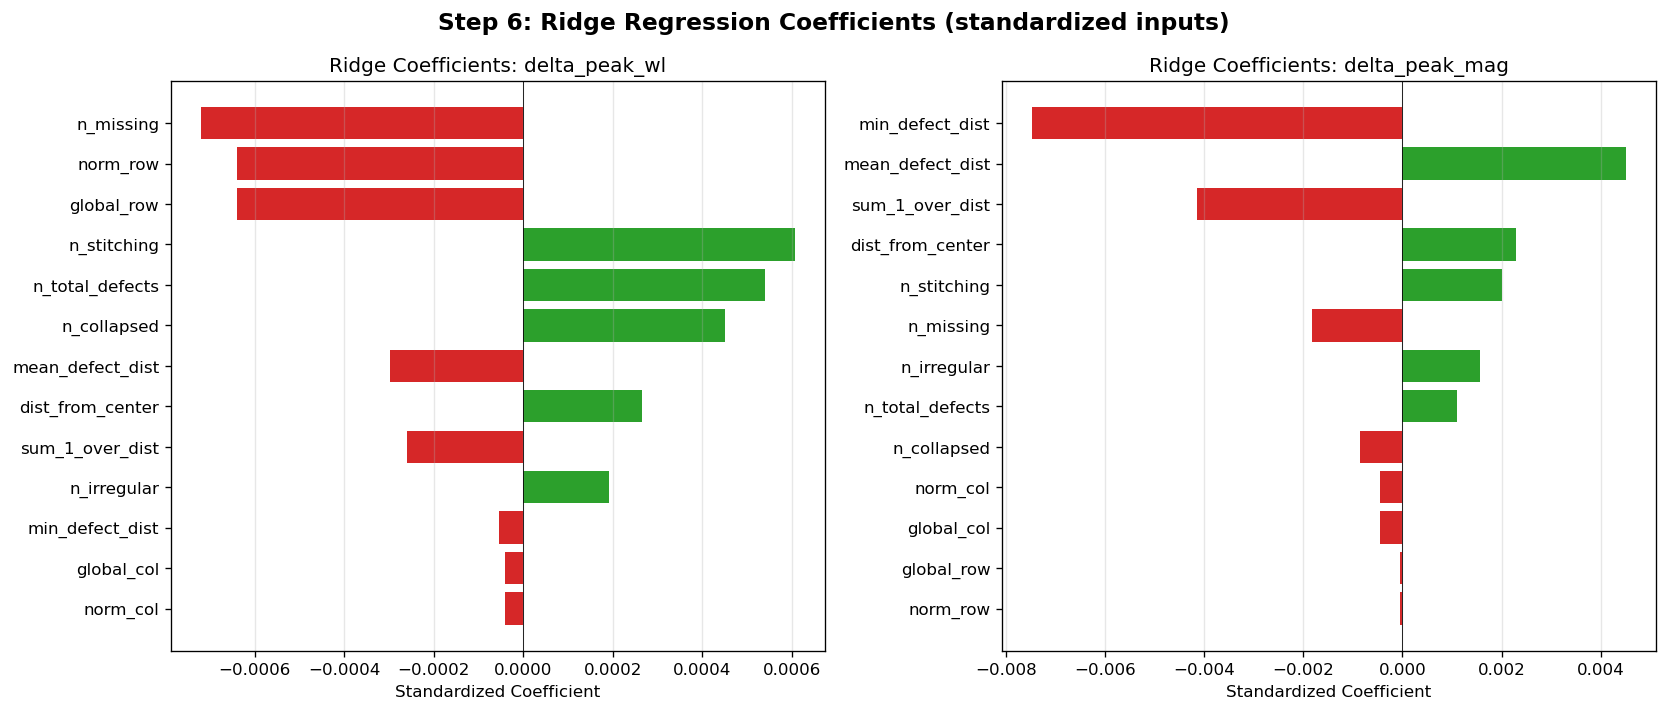

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, results_dict, target_name in zip(
    axes, [results_wl, results_mag], ['delta_peak_wl', 'delta_peak_mag']
):
    coef_df = ml_models.get_coefficient_df(
        results_dict['Ridge'], dataset_assembly.INPUT_COLS
    )
    if coef_df is not None:
        colors_coef = ['#d62728' if v < 0 else '#2ca02c'
                       for v in coef_df['coefficient'][::-1]]
        ax.barh(coef_df['feature'][::-1], coef_df['coefficient'][::-1],
                color=colors_coef)
        ax.axvline(0, color='black', linewidth=0.5)
        ax.set_xlabel('Standardized Coefficient')
        ax.set_title(f'Ridge Coefficients: {target_name}')
        ax.grid(True, alpha=0.3, axis='x')

fig.suptitle('Step 6: Ridge Regression Coefficients (standardized inputs)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step6_ridge_coefficients.png'), dpi=150, bbox_inches='tight')
plt.show()

### 6.5 Residuals vs defect count, distance from center, defect proximity

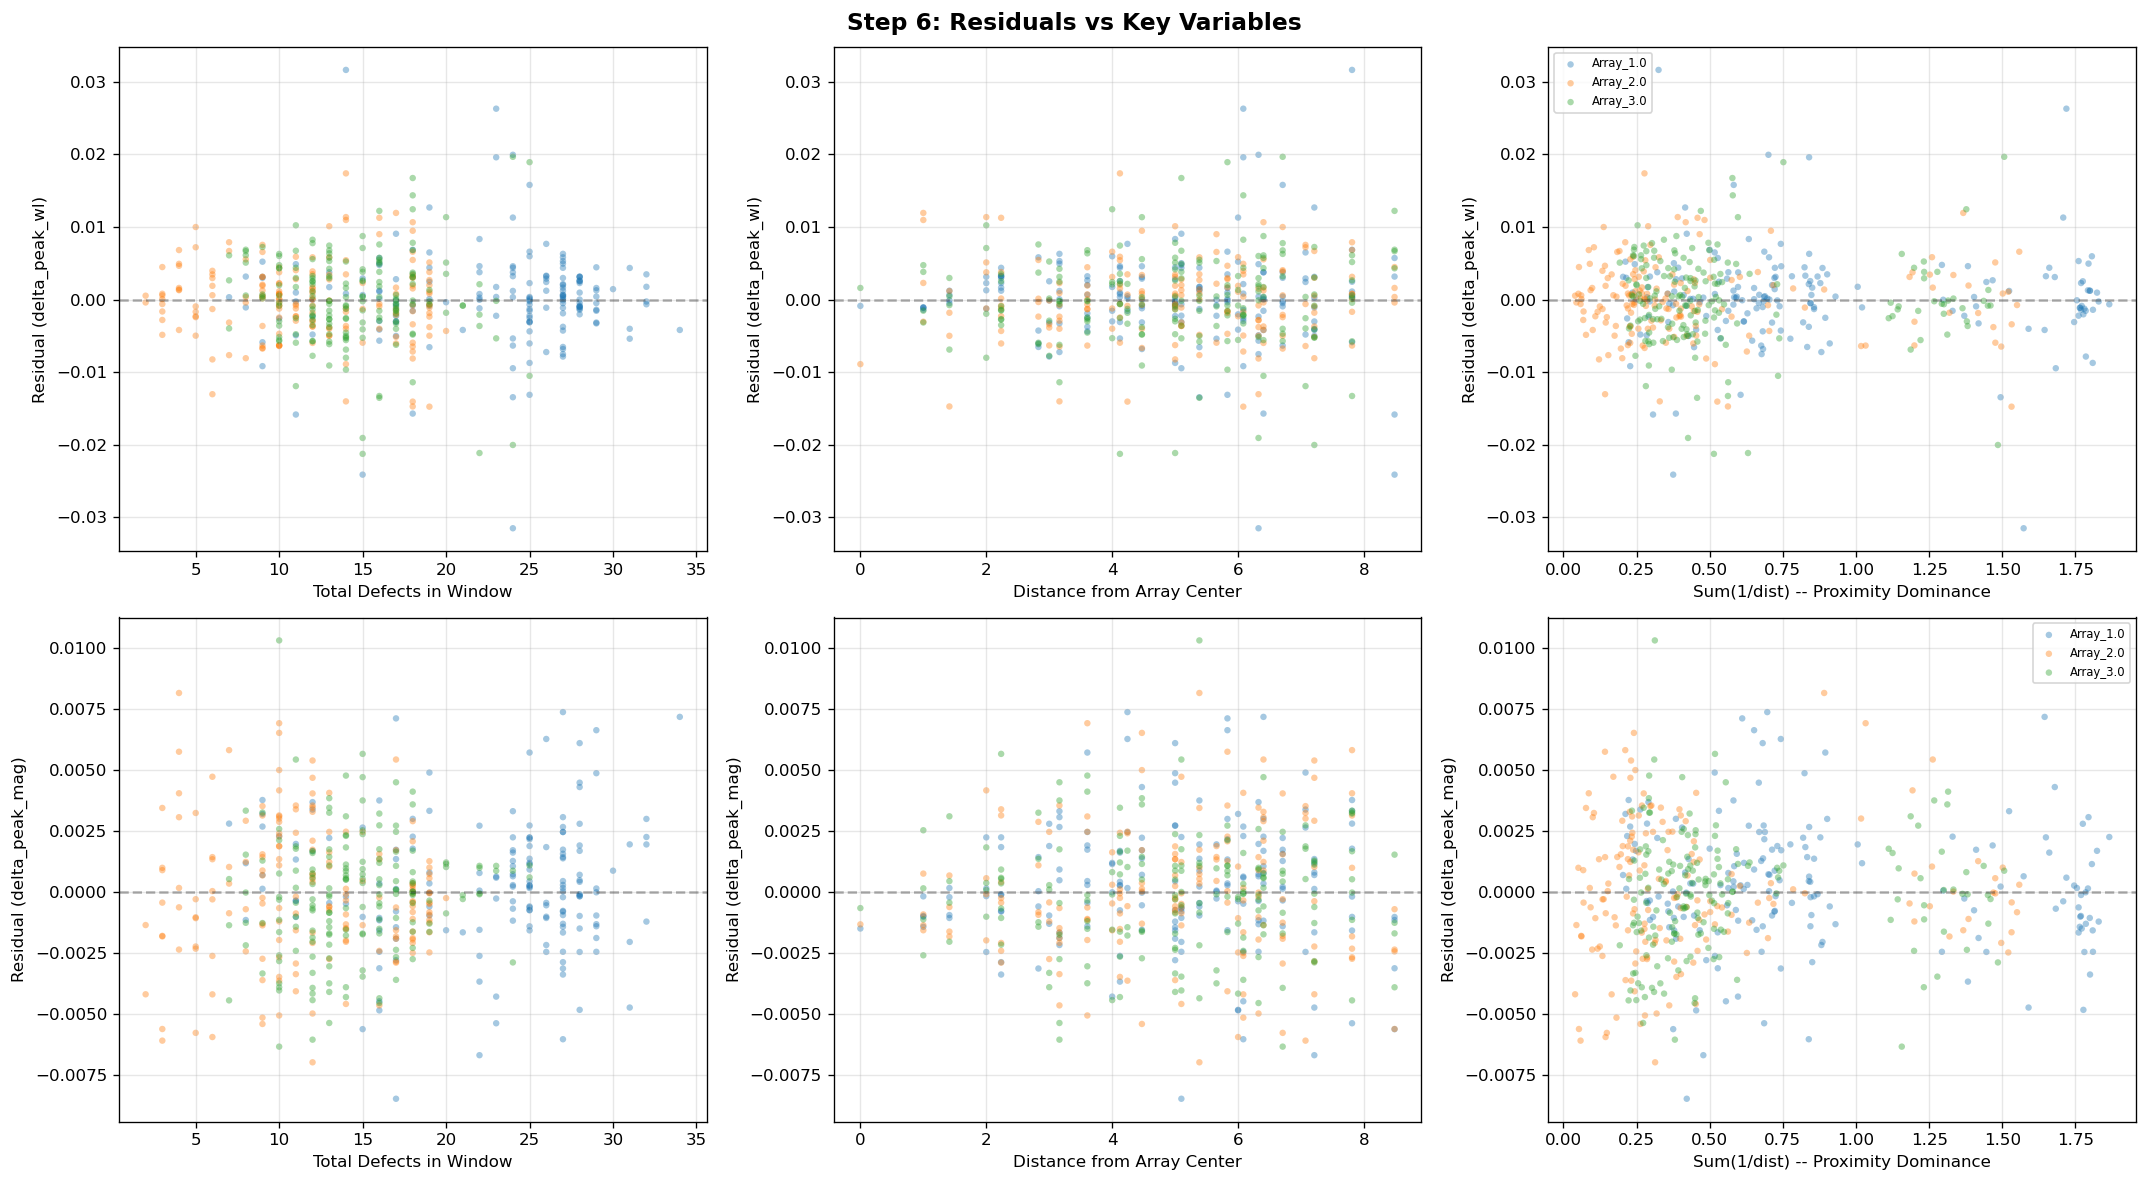

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

x_vars = ['n_total_defects', 'dist_from_center', 'sum_1_over_dist']
x_labels = ['Total Defects in Window', 'Distance from Array Center',
            'Sum(1/dist) -- Proximity Dominance']

for col_idx, (xv, xl) in enumerate(zip(x_vars, x_labels)):
    for row_idx, (resid, target_name) in enumerate([
        ('resid_wl', 'delta_peak_wl'),
        ('resid_mag', 'delta_peak_mag')
    ]):
        ax = axes[row_idx, col_idx]
        for stem, color in zip(array_stems_labeled, colors_arr):
            mask = master_filled['array'] == stem
            ax.scatter(master_filled.loc[mask, xv], master_filled.loc[mask, resid],
                       s=15, alpha=0.4, color=color, label=stem, edgecolors='none')
        ax.axhline(0, color='black', linestyle='--', alpha=0.3)
        ax.set_xlabel(xl)
        ax.set_ylabel(f'Residual ({target_name})')
        ax.grid(True, alpha=0.3)
        if col_idx == 2:
            ax.legend(fontsize=7)

fig.suptitle('Step 6: Residuals vs Key Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step6_residuals_vs_variables.png'), dpi=150, bbox_inches='tight')
plt.show()

### 6.6 Partial dependence plots

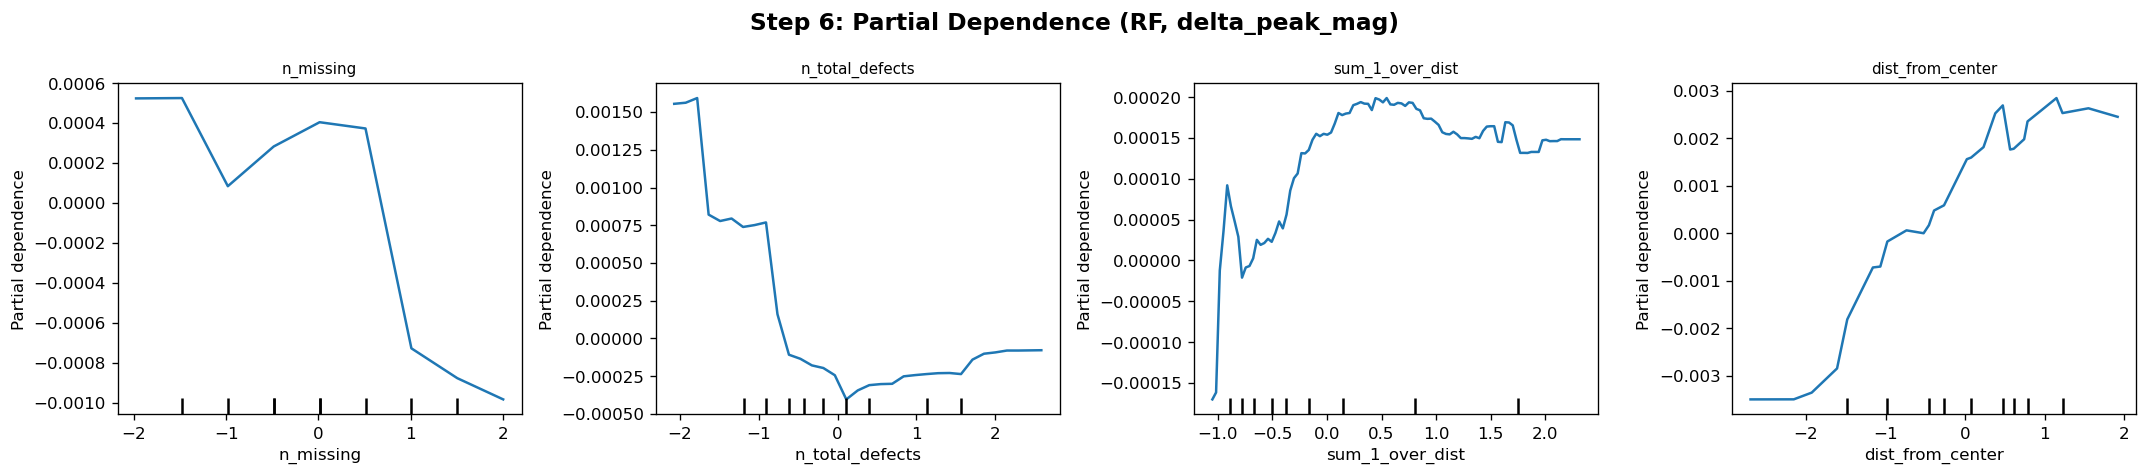

In [20]:
from sklearn.inspection import PartialDependenceDisplay

# Partial dependence for RF on delta_peak_mag (typically more interpretable)
rf_mag = results_mag['RF']
X_scaled = rf_mag['scaler'].transform(X)

pdp_features = [0, 4, 7, 10]  # n_missing, n_total_defects, sum_1_over_dist, dist_from_center
pdp_names = [dataset_assembly.INPUT_COLS[i] for i in pdp_features]

fig, axes = plt.subplots(1, len(pdp_features), figsize=(18, 4))

for ax, feat_idx, feat_name in zip(axes, pdp_features, pdp_names):
    PartialDependenceDisplay.from_estimator(
        rf_mag['model'], X_scaled, [feat_idx],
        feature_names=dataset_assembly.INPUT_COLS,
        ax=ax, kind='average'
    )
    ax.set_title(feat_name, fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle('Step 6: Partial Dependence (RF, delta_peak_mag)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step6_partial_dependence.png'), dpi=150, bbox_inches='tight')
plt.show()

### 6.7 Target vs defect count (raw trends)

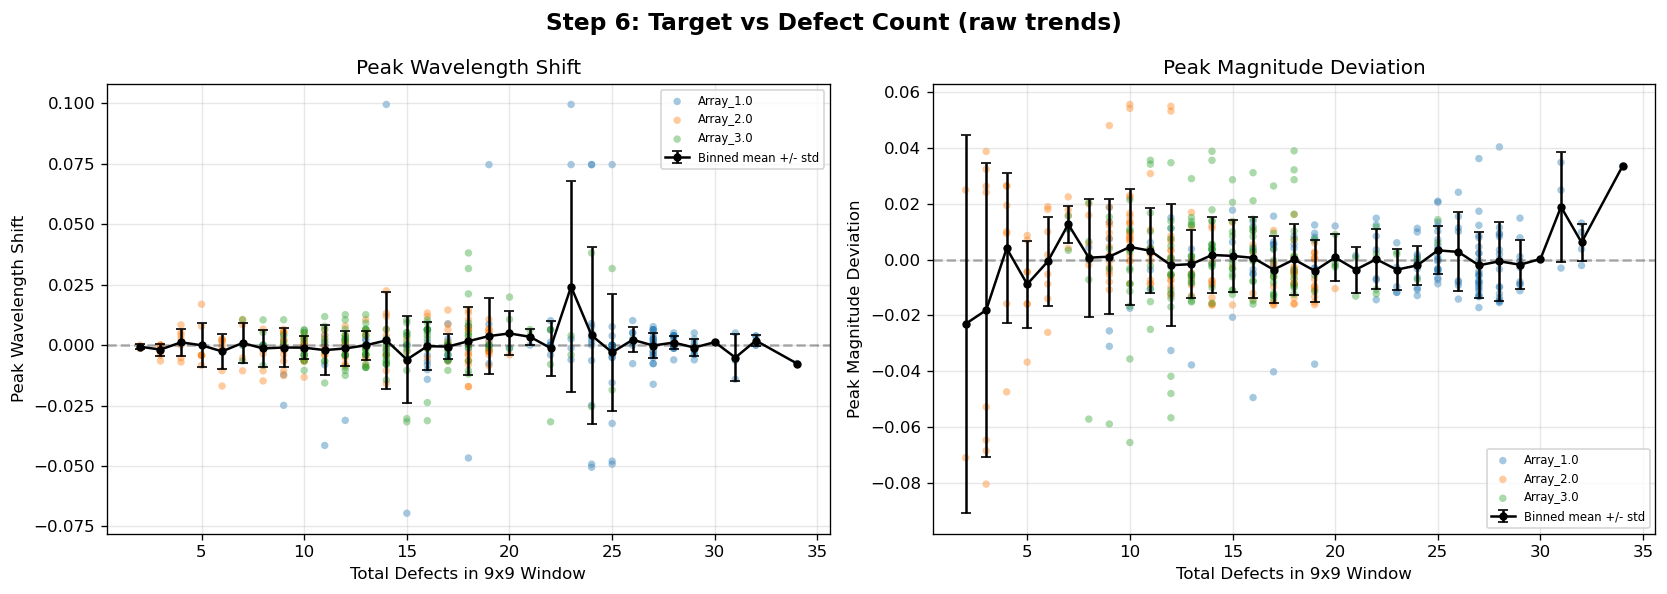

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, target, title in zip(
    axes,
    ['delta_peak_wl', 'delta_peak_mag'],
    ['Peak Wavelength Shift', 'Peak Magnitude Deviation']
):
    for stem, color in zip(array_stems_labeled, colors_arr):
        arr_df = master_filled[master_filled['array'] == stem]
        ax.scatter(arr_df['n_total_defects'], arr_df[target],
                   s=20, alpha=0.4, color=color, label=stem, edgecolors='none')
    
    # Add binned mean trend
    grouped = master_filled.groupby('n_total_defects')[target].agg(['mean', 'std'])
    ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'],
                fmt='ko-', markersize=4, linewidth=1.5, capsize=3,
                label='Binned mean +/- std')
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('Total Defects in 9x9 Window')
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Step 6: Target vs Defect Count (raw trends)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step6_target_vs_defect_count.png'), dpi=150, bbox_inches='tight')
plt.show()

### 6.8 Model comparison summary

In [22]:
print('\n=== MODEL COMPARISON ===')
print()

summary_rows = []
for target_name, results_dict in [('delta_peak_wl', results_wl), ('delta_peak_mag', results_mag)]:
    print(f'--- {target_name} ---')
    for model_name, res in results_dict.items():
        ml_models.model_summary(res, model_name)
        summary_rows.append({
            'target': target_name,
            'model': model_name,
            'mean_r2': res['mean_r2'],
            'mean_rmse': res['mean_rmse'],
        })
    print()

summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))


=== MODEL COMPARISON ===

--- delta_peak_wl ---
  Ridge            R2=-0.0177  RMSE=0.013830
  ElasticNet       R2=-0.0073  RMSE=0.013745
  RF               R2=+0.0948  RMSE=0.012901

--- delta_peak_mag ---
  Ridge            R2=+0.0625  RMSE=0.016055
  ElasticNet       R2=-0.0050  RMSE=0.016615
  RF               R2=+0.9126  RMSE=0.004853

        target      model   mean_r2  mean_rmse
 delta_peak_wl      Ridge -0.017710   0.013830
 delta_peak_wl ElasticNet -0.007285   0.013745
 delta_peak_wl         RF  0.094763   0.012901
delta_peak_mag      Ridge  0.062460   0.016055
delta_peak_mag ElasticNet -0.004985   0.016615
delta_peak_mag         RF  0.912564   0.004853


---
## Observations

### Key Findings (fill in after running):

1. **Baseline quality**: How many zero-defect windows per array? Consistency of ideal spectra?
2. **Perturbative behavior**: Do targets show smooth, monotonic trends with defect count?
3. **Spatial bias vs defect effects**: Are residuals spatially structured or random?
4. **Feature dominance**: Which features drive predictions (defect count? proximity? spatial position)?
5. **Model comparison**: Linear vs tree-based -- is the relationship linear or nonlinear?